<a href="https://colab.research.google.com/github/adilabduakhanov/Colab-Projects/blob/main/Copywriter_for_video_(Youtube%2C_VK_%D0%B2%D0%B8%D0%B4%D0%B5%D0%BE%2C_RuTube).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

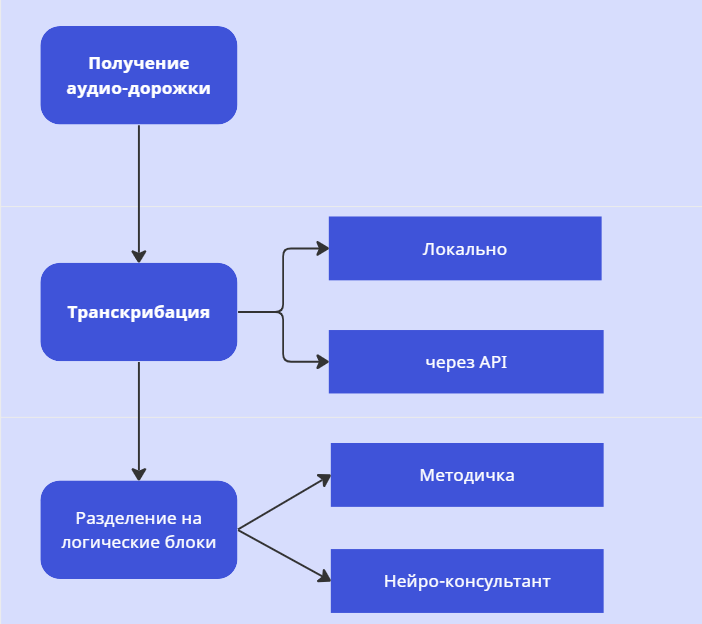

В данном ноутбуке мы на основании видео (Youtube, VK, RuTube):
- получаем аудио-дорожку из видео
- транскрибируем аудио (перевод в текст) при помощи моделей:
    - Whisper (локально)
    - Whisper (online) от openAI
- создаем нейро-консультанта
- создаем методичку по основным моментам данной лекции

In [ ]:
#@title Устанавливаем необходимые библиотеки

# Библиотека для загрузки видео https://github.com/yt-dlp/yt-dlp
!pip install -q yt-dlp
# Библиотека транскрибации (STT) https://github.com/openai/whisper
!pip install -q git+https://github.com/openai/whisper.git

!apt install ffmpeg -y
!pip install -q openai langchain langchain_core langchain_community \
langchain-openai faiss-cpu tiktoken python-docx==1.1.2 pydub

from IPython.display import clear_output
clear_output() # очистка


In [ ]:
#@title Импортируем библиотеки

import yt_dlp
import whisper
from pydub import AudioSegment
import textwrap
import matplotlib.pyplot as plt
from IPython.display import Audio
import os
import re
import time
import tiktoken
import openai
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_community.vectorstores import FAISS
import os
import shutil
from pprint import pprint as pp
from google.colab import userdata, drive


# Получение ключа API OpenAI из секретов Колаба и установка как переменную окружения
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# Извлекаем аудио-дорожку из видео контента

In [ ]:
# Извлекаем Аудио-дорожку из Видео контента (Youtube, VK, RuTube)
def get_audio_from_video(url: str,
                         folder: str,
                         audio_file_name: str):
    path_file = f'{folder}{audio_file_name}'
    ydl_opts = {'format': 'm4a/bestaudio/best',
                'postprocessors': [{'key': 'FFmpegExtractAudio',
                                    'preferredcodec': 'm4a'}],
                'outtmpl': path_file}
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            error_code = ydl.download(url)
            if error_code == 0:
                print('Загрузка файла прошла успешно!')
            else:
                print(f'Код ошибки: {error_code}')
        print(f"\nАудиофайл загружен: {path_file}.m4a")
        return f'{path_file}.m4a'
    except:
        return None


# Информация об аудио файлe
def audio_info(audio_file):
    audio = AudioSegment.from_file(audio_file)
    print(f'\nПродолжительность: {audio.duration_seconds / 60} min.')
    print(f'Частота дискретизаци: {audio.frame_rate}')
    print(f'Количество каналов: {audio.channels}')
    return audio

# Пример: Получаем Аудио из Youtube видео

In [ ]:
# Пример: Получаем Аудио из Youtube видео
url= 'https://www.youtube.com/shorts/vBafTBRhKys'
folder = '/content/'
audio_file_name = 'audio_youtube'

audio_file = get_audio_from_video(url, folder, audio_file_name)
_ = audio_info(audio_file)

[youtube] Extracting URL: https://www.youtube.com/shorts/vBafTBRhKys
[youtube] vBafTBRhKys: Downloading webpage
[youtube] vBafTBRhKys: Downloading ios player API JSON
[youtube] vBafTBRhKys: Downloading mweb player API JSON
[youtube] vBafTBRhKys: Downloading m3u8 information
[info] vBafTBRhKys: Downloading 1 format(s): 140
[download] /content/audio_youtube.m4a has already been downloaded
[ExtractAudio] Not converting audio /content/audio_youtube.m4a; file is already in target format m4a
Загрузка файла прошла успешно!

Аудиофайл загружен: /content/audio_youtube.m4a

Продолжительность: 0.7426515495086924 min.
Частота дискретизаци: 44100
Количество каналов: 2


# Пример: Получаем Аудио из VK видео

In [ ]:
# Пример: Получаем Аудио из VK видео
url= 'https://vkvideo.ru/video-221611983_456239031'
folder = '/content/'
audio_file_name = 'audio_vk'

audio_file = get_audio_from_video(url, folder, audio_file_name)
_ = audio_info(audio_file)

[vk] Extracting URL: https://vkvideo.ru/video-221611983_456239031
[vk] -221611983_456239031: Downloading JSON metadata
[vk] -221611983_456239031: Downloading MPD manifest
[vk] -221611983_456239031: Downloading m3u8 information
[info] -221611983_456239031: Downloading 1 format(s): dash_sep-11
[download] Destination: /content/audio_vk
[download] 100% of    8.05MiB in 00:00:02 at 3.84MiB/s   
[FixupM4a] Correcting container of "/content/audio_vk"
[ExtractAudio] Destination: /content/audio_vk.m4a
Deleting original file /content/audio_vk (pass -k to keep)
Загрузка файла прошла успешно!

Аудиофайл загружен: /content/audio_vk.m4a

Продолжительность: 4.377348450491308 min.
Частота дискретизаци: 44100
Количество каналов: 2


# Пример: Получаем Аудио из видео RuTube

In [ ]:
# Пример: Получаем Аудио из видео RuTube

url = 'https://rutube.ru/video/123e83369e45455ea5a9a85a4f6db3f1/'
folder = '/content/'
title = "Python. Первая программа. Переменные"

audio_file = get_audio_from_video(url, folder, title)
_ = audio_info(audio_file)

[rutube] Extracting URL: https://rutube.ru/video/123e83369e45455ea5a9a85a4f6db3f1/
[rutube] 123e83369e45455ea5a9a85a4f6db3f1: Downloading video JSON
[rutube] 123e83369e45455ea5a9a85a4f6db3f1: Downloading options JSON
[rutube] 123e83369e45455ea5a9a85a4f6db3f1: Downloading m3u8 information
[rutube] 123e83369e45455ea5a9a85a4f6db3f1: Downloading m3u8 information
[info] 123e83369e45455ea5a9a85a4f6db3f1: Downloading 1 format(s): m3u8-450-1
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 269
[download] Destination: /content/Python. Первая программа. Переменные
[download] 100% of   63.02MiB in 00:01:30 at 715.00KiB/s                 
[FixupM3u8] Fixing MPEG-TS in MP4 container of "/content/Python. Первая программа. Переменные"
[ExtractAudio] Destination: /content/Python. Первая программа. Переменные.m4a
Deleting original file /content/Python. Первая программа. Переменные (pass -k to keep)
Загрузка файла прошла успешно!

Аудиофайл загружен: /content/Python. Первая программа. 

# Транскрибация. Вариант 1: Whisper (локально)

In [ ]:
# Используем ранее созданное аудио: "/content/audio_youtube.m4a"

audio_info("/content/audio_youtube.m4a")


Продолжительность: 0.7426515495086924 min.
Частота дискретизаци: 44100
Количество каналов: 2


In [ ]:
# так можно посмотреть доступные параметры
!whisper --help

In [ ]:
# Используем Whisper для транскрибации аудиофайла (модель turbo)
# https://github.com/openai/whisper/blob/main/README.md
# Вариант (GPU): через команды в терминале

!whisper '/content/audio_youtube.m4a' --model turbo --language ru --output_format txt


/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
[00:00.000 --

In [ ]:
# Вариант (GPU видеокарта T4): код python
model = whisper.load_model('turbo')

start_time = time.time()
pp(model.transcribe("/content/audio_youtube.m4a", language="ru")['text'])
print(f'Время выпонения: {time.time() - start_time} минут') # достаточно долго, даже на GPU )

(' Как узнать процент заряда батареи с помощью Python? Подпишись, сейчас '
 'расскажу. Установим необходимый для работы модуль PSUtil. Импортируем. '
 'Обращаемся к модулю и используем метод SensorsBattery, который возвращает '
 'нам информацию о батарее устройства. Получим заряд в процентах, '
 'воспользовавшись атрибутом %, приравняв его к целому числу. А после выведем '
 'результат на печать. Запускаем скрипт. И получаем остаток заряда батареи '
 'устройства в процентах. Пользуйся на здоровье!')
Время выпонения: 2.1373472213745117 минут


# Транскрибация. Вариант 2: Whisper (online)

- Документация:
    - https://platform.openai.com/docs/guides/speech-to-text
    - https://platform.openai.com/docs/api-reference/audio/createTranscription

- Audio models: Whisper - Price: $0.006 / minute (rounded to the nearest second)
    - https://openai.com/api/pricing

In [ ]:
# Транскрибация аудио в текст (OpenAI - whisper)
def transcribe_audio_whisper(audio_path,
                             file_title,
                             save_folder_path,
                             max_duration=10*60*1000):  # 10 минут
    """
    Функция для транскрибации аудиофайла по частям, чтобы соответствовать ограничениям размера API.
    """
    # Создание папки для сохранения результатов, если она ещё не существует
    os.makedirs(save_folder_path, exist_ok=True)
    # Загрузка аудиофайла
    audio = AudioSegment.from_file(audio_path)
    # Создание временной папки в колабе для хранения аудио фрагментов
    temp_dir = os.path.join('/content/', "temp_audio_chunks")
    os.makedirs(temp_dir, exist_ok=True)
    # Инициализация переменных для обработки аудио фрагментов
    current_start_time = 0  # Текущее время начала фрагмента
    chunk_index = 1         # Индекс текущего фрагмента
    transcriptions = []     # Список для хранения всех транскрибаций

    # Обработка аудиофайла частями
    while current_start_time < len(audio):
        # Выделение фрагмента из аудиофайла
        chunk = audio[current_start_time:current_start_time + max_duration]
        # Формирование имени и пути файла фрагмента
        chunk_name = f"chunk_{chunk_index}.mp3"
        chunk_path = os.path.join(temp_dir, chunk_name)
        # Экспорт фрагмента
        chunk.export(chunk_path, format="mp3")

        # Проверка размера файла фрагмента на соответствие лимиту API
        if os.path.getsize(chunk_path) > 26000000:  # почти 25 MB
            print(f"Chunk {chunk_index} exceeds the maximum size limit for the API. Trying a smaller duration...")
            max_duration = int(max_duration * 0.8)  # Уменьшение длительности фрагмента
            os.remove(chunk_path)  # Удаление фрагмента, превышающего лимит
            continue

        # Открытие файла фрагмента для чтения в двоичном режиме
        with open(chunk_path, "rb") as src_file:
            print(f"Transcribing {chunk_name}...")
            try:
                # Запрос на транскрибацию фрагмента с использованием модели Whisper
                transcript_response = openai.audio.transcriptions.create(
                    model="whisper-1",
                    file=src_file)
                # Добавление результата транскрибации в список транскрипций
                transcriptions.append(transcript_response.text)
            except openai.BadRequestError as e:
                print(f"An error occurred: {e}")
                break
        # Переход к следующему фрагменту
        current_start_time += max_duration
        chunk_index += 1

    # Сохранение всех транскрибаций в один текстовый файл
    result_text = "\n".join(transcriptions)
    result_path = os.path.join(save_folder_path, f"{file_title}.txt")
    with open(result_path, "w") as txt_file:
        txt_file.write(result_text)
    print(f"Transcription saved to {result_path}")

    # Удаляем временную папку и все файлы в ней
    shutil.rmtree(temp_dir)
    return result_text

In [ ]:
# Пример - Транскрибация whisper (online)
audio_path = '/content/audio_youtube.m4a'
file_title = 'text_youtube'
save_folder_path = '/content/'

res_text = transcribe_audio_whisper(audio_path, file_title, save_folder_path)
pp(res_text)

Transcribing chunk_1.mp3...
Transcription saved to /content/text_youtube.txt
('Как узнать процент заряда батареи с помощью Python? Подпишись, сейчас '
 'расскажу. Установим необходимый для работы модуль PSUtil. Импортируем. '
 'Обращаемся к модулю и используем метод sensorsBattery, который возвращает '
 'нам информацию о батарее устройства. Получим заряд в процентах, '
 'воспользовавшись атрибутом % приравняв его к целому числу. А после выведем '
 'результат на печать. Запускаем скрипт и получаем остаток заряда батареи '
 'устройства в процентах. Пользуйся на здоровье.')


In [ ]:
# Подключаем ГуглДиск для работы с файлами
drive.mount('/content/drive')
# Формируем путь на ГуглДиске для работы с файлами
path_drive = '/content/drive/MyDrive/data/neuro_copy_writer/'
# Создаем папку. Если папка уже создана ранее, то данные сохранятся
os.makedirs(path_drive, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Получаем Аудио из VK видео
url= 'https://vkvideo.ru/video-123851409_456239255'
audio_file_name = 'Квантовая физика - от головоломки до технологий'

_ = get_audio_from_video(url, path_drive, audio_file_name)

[vk] Extracting URL: https://vkvideo.ru/video-123851409_456239255
[vk] -123851409_456239255: Downloading JSON metadata
[vk] -123851409_456239255: Downloading MPD manifest
[info] -123851409_456239255: Downloading 1 format(s): dash_webm-8
[download] Destination: /content/drive/MyDrive/data/neuro_copy_writer/Квантовая физика - от головоломки до технологий
[download] 100% of   73.75MiB in 00:00:05 at 14.25MiB/s  
[ExtractAudio] Destination: /content/drive/MyDrive/data/neuro_copy_writer/Квантовая физика - от головоломки до технологий.m4a
Deleting original file /content/drive/MyDrive/data/neuro_copy_writer/Квантовая физика - от головоломки до технологий (pass -k to keep)
Загрузка файла прошла успешно!

Аудиофайл загружен: /content/drive/MyDrive/data/neuro_copy_writer/Квантовая физика - от головоломки до технологий.m4a


In [ ]:
# Аудио файл с гугл диска
audio_path = os.path.join(path_drive, "Квантовая физика - от головоломки до технологий.m4a")
_ = audio_info(audio_path)


Продолжительность: 51.188027777777776 min.
Частота дискретизаци: 48000
Количество каналов: 2


In [ ]:
# Транскрибация с сохранением текстового файла на Гугл диск

# Аудио файл с гугл диска
audio_path = os.path.join(path_drive, "Квантовая физика - от головоломки до технологий.m4a")
file_title = 'Квантовая физика - от головоломки до технологий'
start_time = time.time()

res_text = transcribe_audio_whisper(audio_path, file_title, path_drive)

print(f'\nВремя выпонения: {time.time() - start_time} секунд.\n')
# Фрагмент текста
pp(res_text[:1000])

Transcribing chunk_1.mp3...
Transcribing chunk_2.mp3...
Transcribing chunk_3.mp3...
Transcribing chunk_4.mp3...
Transcribing chunk_5.mp3...
Transcribing chunk_6.mp3...
Transcription saved to /content/drive/MyDrive/data/neuro_copy_writer/Квантовая физика - от головоломки до технологий.txt

Время выпонения: 282.3615155220032 секунд.

('Добрый вечер! Рад вас видеть в этот понедельник. Надеюсь, что вы не устали '
 'сегодня, у вас остались силы для того, чтобы получать новые знания. И я рад '
 'вас приветствовать в нашем уже традиционном третьем научном лектории. '
 'Спасибо, что вы пришли. И сегодня у нас, как всегда, прекрасный, '
 'замечательный гость. Я хочу немножечко его представить. Это руководитель '
 'научной группы квантовой информационной технологии Российского Квантового '
 'Центра, директор Института физики и квантовой инженерии университета МИСИС, '
 'член Координационного совета по делам молодежи в научной и образовательных '
 'сферах Совета президента Российской Федерации по

# Создание текстовой методички по теме видео

In [ ]:
# @title Функции

# Функция для форматирования текста по абзацам
def format_text(text, width=120):
    # Разделяем текст на абзацы
    paragraphs = text.split('\n')
    # Форматируем каждый абзац отдельно
    formatted_paragraphs = []
    for paragraph in paragraphs:
        # Используем textwrap.fill для форматирования абзаца, чтобы длина строки не превышала width
        formatted_paragraph = textwrap.fill(paragraph, width)
        formatted_paragraphs.append(formatted_paragraph)
    # Объединяем абзацы с символом новой строки
    return '\n'.join(formatted_paragraphs)


# Функция возвращает количество токенов в строке в зависимости от используемой модели
def num_tokens_from_string(string: str, model='gpt-4o-mini') -> int:
    # Получаем имя кодировки для указанной модели
    encoding_name = tiktoken.encoding_for_model(model).name
    # Получаем объект кодировки на основе имени кодировки
    encoding = tiktoken.get_encoding(encoding_name)
    # Кодируем строку и вычисляем количество токенов
    num_tokens = len(encoding.encode(string)) + 10
    # Возвращаем количество токенов
    return num_tokens


# Построение гистограммы распределения количества токенов по чанкам (если нужно)
def create_histogram(chunks):
    print("\nОбщее количество чанков: ", len(chunks))
    # Подсчет токенов для каждого чанка
    try: # для формата чанков LangChain Document
        chunk_token_counts = [num_tokens_from_string(chunk.page_content) for chunk in chunks]
    except: # для текстового формата чанков
        chunk_token_counts = [num_tokens_from_string(chunk) for chunk in chunks]
    # Строим гистограмму
    plt.figure(figsize=(7, 4)) # размер
    plt.hist(chunk_token_counts, bins=10, alpha=0.5, label='Чанки')
    plt.title('Распределение к-ва токенов по чанкам')  # Заголовок графика
    plt.xlabel('К-во токенов в чанке')  # Подпись оси X
    plt.ylabel('К-во чанков')  # Подпись оси Y
    plt.show()  # Отображаем график


# (CharacterTextSplitter) Формируем чанки из текста по количеству символов
def split_text(text: str,
               chunk_size=30000,    # Ограничение к-ва символов (не токенов) в чанке
               chunk_overlap=1000): # к-во символов перекрытия в чанке
    # Удалить пустые строки и лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    # Создаем экземпляр CharacterTextSplitter с заданными парамаетрами
    splitter = CharacterTextSplitter(chunk_size=chunk_size,
                                     chunk_overlap=chunk_overlap,
                                     separator=" ")
    return splitter.split_text(text) # список текстовых чанков


# (MarkdownHeaderTextSplitter)
# Формируем чанки в формат LangChain Document из текста с Markdown разметкой
def split_markdown_text(markdown_text,
                        strip_headers=False): # НЕ удалять заголовки под '#..' из page_content
    # strip_headers=False  - Заголовки будут сохраняться в page_content и в metadata
    # Определяем заголовки, по которым будем разбивать текст
    headers_to_split_on = [("#", "Header 1"),   # Заголовок первого уровня
                           ("##", "Header 2"),  # Заголовок второго уровня
                           ("###", "Header 3")] # Заголовок третьего уровня
    # Создаем экземпляр MarkdownHeaderTextSplitter с заданными заголовками
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on,
                                                   strip_headers=strip_headers)
    # Разбиваем текст на чанки в формат LangChain Document
    return markdown_splitter.split_text(markdown_text)


# Функция получения ответа от модели
def generate_answer(system, user, text, temp=0.3, model='gpt-4o-mini'):
    messages = [
        {'role': 'system', 'content': system},
        {'role': 'user', 'content': user + '\n' + text}]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp)
    return completion.choices[0].message.content


# Обработка текстовых чанков по очереди (если нужно)
def process_text_chunks(text_chunks, system, user):
    processed_text = ''
    for chunk in text_chunks:
        # получение ответа от модели для каждого чанка
        answer = generate_answer(system, user, chunk)
        processed_text += f'{answer}\n\n'  # Добавляем ответ в результат
    return processed_text

In [ ]:
# @title Загрузка текста и определения размера

# Текстовый файл с гугл диска
text_file = os.path.join(path_drive, "Квантовая физика - от головоломки до технологий.txt")
with open(text_file, 'r', encoding='utf-8') as txt_file:
    text = txt_file.read()

# Количество токенов во всем тексте
print(f'Количество токенов во всем тексте: {num_tokens_from_string(text)}\n')

Количество токенов во всем тексте: 13418



In [ ]:
# @title Обработка текста

# В зависимости от размера контекстного окна (в токенах) для разных моделей мы можем подать разный объем текста
# Если текст небольшой, мы можем весь текст отправить в модель, без деления на чанки
# И получим ответ примерно на такое же количество токенов (по условиям промпта - сохранение 100% текста)

system = """Вы гений текста, копирайтинга, писательства. Ваша задача распознать разделы в тексте
и разбить его на эти разделы сохраняя весь текст на 100%"""

user = """Пожалуйста, давайте подумаем шаг за шагом: Подумайте, какие разделы в тексте вы можете
распознать и какое название по смыслу можно дать каждому разделу. Далее напишите ответ по всему
предыдущему ответу и оформи в порядке:
## Название раздела, после чего весь текст, относящийся к этому разделу. Текст:"""

# Подали весь текст в модель без деления на чанки
processed_md_text = generate_answer(system, user, text)
# Записываем processed_md_text в файл на гугл диск
with open(os.path.join(path_drive, 'processed_md_text.txt'), "w") as txt_file:
    txt_file.write(processed_md_text)

In [ ]:
# Если размер всего текста превышает размер контекстного окна модели в токенах, разделим его на чанки

# Разбиваем текст на чанки
text_chunks = split_text(text, chunk_size=30000, chunk_overlap=1000)
# Гистограмма распределения количества токенов по чанкам
create_histogram(text_chunks)
# Обработка текстовых чанков по очереди
processed_md_text = process_text_chunks(text_chunks, system, user)
# Записываем processed_md_text в файл на гугл диск
with open(os.path.join(path_drive, 'processed_md_text_2.txt'), "w") as txt_file:
    txt_file.write(processed_md_text)

Итак, мы получили текст транскрибации, разделенный на разделы с названиями данных разделов ("processed_md_text.txt"). Теперь разделим этот текст на чанки при помощи MarkdownHeaderTextSplitter, создадим из него векторную базу Faiss и сделаем нейро-консультанта, который отвечает на вопросы по тексту, а из текста транскрибации с разделами составим методичку.

In [ ]:
# Текстовый файл processed_md_text.txt с гугл диска
text_file = os.path.join(path_drive, "processed_md_text.txt")
with open(text_file, 'r', encoding='utf-8') as txt_file:
    text_md = txt_file.read()

# Получаем список документов, разбитых по заголовкам
chunks_md_splits = split_markdown_text(text_md)

print('Заголовки: \n')
for chunk in chunks_md_splits:
    print(chunk.metadata['Header 2'])

Заголовки: 

Введение
Приветствие и представление
Введение в квантовую физику
История физики до квантовой теории
Нерешенные задачи физики
Проблемы физики: Ультрафиолетовая катастрофа и модели атомов
Радикальные гипотезы и квантовая физика
Социальное явление в физике
Изменение научной картины мира
Современные исследования в физике
Квантовая физика и философия
Приборы и устройства на основе квантовой физики
Различие между первой и второй квантовой волной
Ключевые вопросы квантовых технологий
Принцип суперпозиции и квантовая запутанность
Спор Эйнштейна и Бора
Проблемы наблюдения квантовых состояний
Применение квантовых технологий
Квантовые вычисления
Идея квантовых компьютеров
Параллельное развитие идей
Определение квантового компьютера
Модели квантовых компьютеров
Построение квантового компьютера
Квантовые алгоритмы
Принципы работы квантовых компьютеров
Подходы к построению квантовых компьютеров
Прогресс в квантовых вычислениях в России
Программирование квантовых компьютеров
Эмуляция ква

In [ ]:
#@title Формируем методичку

system = """Ты гений копирайтинга. Ты получаешь раздел необработанного текста по определенной теме.
Нужно из этого текста выделить самую суть, только самое важное, сохранив все нужные подробности и детали,
но убрав всю "воду" и слова (предложения), не несущие смысловой нагрузки."""

user = """Из данного текста выдели только ключевую и ценную с точки зрения темы раздела информацию.
Удали всю "воду". В итоге у тебя должен получится раздел для методички по указанной теме. Опирайся
только на данный тебе текст, не придумывай ничего от себя. Ответ нужен в формате:
## Название раздела, и далее выделенная тобой ценная информация из текста."""


# Обработка каждого чанка (документа) для формирования методички
def process_documents(path_drive, documents, system, user):
    """
    Функция принимает папку для сохранения файла, чанки, system, user
    Она обрабатывает каждый документ, конкатенирует результаты в один текст и сохраняет в файл .txt.
    В итоге мы получаем методичку по лекции.
    """
    processed_text_for_handbook = ""  # Строка для конкатенации обработанного текста
    for document in documents:
        # Получаем ответ от модели для каждого документа
        answer = generate_answer(system, user, document.page_content)
        # Добавляем обработанный текст в общую строку
        processed_text_for_handbook += f"{answer}\n\n"
    # Записываем полученный текст в файл
    with open(os.path.join(path_drive, 'short_tutorial.txt'), 'w', encoding='utf-8') as f:
        f.write(processed_text_for_handbook)
    return processed_text_for_handbook


# Создание методички и запись текста методички на Гугл Диск
short_tutorial = process_documents(path_drive, chunks_md_splits, system, user)
print(f"Обработанный текст сохранен в файле: {os.path.join(path_drive, 'short_tutorial.txt')}")

Обработанный текст сохранен в файле: /content/drive/MyDrive/data/neuro_copy_writer/short_tutorial.txt


In [ ]:
# Вывод содержимого методички:
with open(os.path.join(path_drive, 'short_tutorial.txt'), 'r', encoding='utf-8') as f:
    processed_text = f.read()

print(format_text(processed_text))

## Введение
Алексей Константинович Федоров — руководитель научной группы квантовой информационной технологии Российского Квантового
Центра, директор Института физики и квантовой инженерии университета МИСИС, член Координационного совета по делам
молодежи в научной и образовательных сферах Совета президента Российской Федерации по науке и образованию, заместитель
председателя научного комитета премии "Вызов", самый молодой профессор МФТИ.

## Введение в квантовые технологии
Квантовые технологии представляют собой уникальное научно-технологическое направление, переходящее от теории к
практическим решениям сложных индустриальных задач. Российский Квантовый Центр занимается как фундаментальными, так и
прикладными аспектами квантовых технологий. В университете МИСИС также ведутся исследования в этой области, включая
образовательные проекты.

## Введение в квантовую физику
Квантовая физика радикально изменила представления о науке. Важно понять, как концепция квантовой теории возникла и
повл

# Создание нейро-консультанта по теме видео

In [ ]:
#@title Функции и создание векторной базы

# Создание индексной (векторной) базы из чанков в формате LangChain Document и сохранение на диск
def create_db_index_from_documents_save(chunks_documents,
                                        index_name, # имя для индексной базы
                                        path):  # путь к папке
    # Создаем индексную базу с использованием FAISS ---------------------------------
    db_index = FAISS.from_documents(chunks_documents,
                                    OpenAIEmbeddings())
    # сохраняем индексную базу ------------------------------------------------------
    db_index.save_local(folder_path=path, # путь к папке (path)
                        index_name=index_name)  # имя для индексной базы (index_name)
    return db_index


# Загрузка векторной базы с диска
def load_db_vector(folder_path_db_index,  # путь к сохраненной векторной базе
                   index_name):           # имя сохраненной векторной базы
    return FAISS.load_local(
                allow_dangerous_deserialization=True, # Разрешает потенциально небезопасную десериализацию
                embeddings=OpenAIEmbeddings(),  # Указывает векторные представления
                folder_path=folder_path_db_index, # путь к сохраненной векторной базе
                index_name=index_name) # имя сохраненной векторной базы


# Функция запроса и ответа от OpenAI с поиском по векторной базе данных
def generate_db_answer(query,    # запрос пользователя
                       db_index, # векторная база знаний
                       k=3,      # используемое к-во чанков
                       verbose=True, # выводить ли на экран выбранные чанки
                       model='gpt-4o-mini',
                       temp=0.3):
    # Поиск чанков по векторной базе данных
    similar_documents = db_index.similarity_search(query, k=k)
    # Формирование текстового контента из выбранных чанков для модели
    message_content = re.sub(r'\n{2}', ' ', '\n '.join(
        [f'Отрывок документа № {i+1}:\n' + doc.page_content
        for i, doc in enumerate(similar_documents)]))
    if verbose:
        print(message_content) # печатать на экран выбранные чанки

    messages = [{"role": "system",
                 "content": f'Ответь подробно на вопрос пользователя на основании информации из базы знаний: \n{message_content}'},
                {"role": "user",
                 "content": f'Вопрос пользователя: {query}'}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp)
    return response.choices[0].message.content


# --------------------------------------------------------------------------------------------------
# Создание и сохранение векторной базы на ГуглДиск
db_vector = create_db_index_from_documents_save(chunks_md_splits, 'db_vector', path_drive)


In [ ]:
# Содержимое папки на ГуглДиске
!ls /content/drive/MyDrive/data/neuro_copy_writer/

 db_vector.faiss   processed_md_text.txt  'Квантовая физика - от головоломки до технологий.m4a'
 db_vector.pkl	   short_tutorial.txt	  'Квантовая физика - от головоломки до технологий.txt'


## Вопросы консультанту

In [ ]:
# Загрузка векторной базы с ГуглДиска
db_vector = load_db_vector(path_drive, 'db_vector')

system = """Ты - преподаватель, эксперт по Квантовой физике. Твоя задача - ответить
на вопрос только на основе представленных тебе документов, не добавляя ничего от себя."""

In [ ]:
query = "Что такое квантовый компьютер?"

answer = format_text(generate_db_answer(query, db_vector))
print(f'\nОтвет косультанта: \n\n{answer}')

Отрывок документа № 1:
## Определение квантового компьютера
Еще раз, что это такое? Это некоторые вычислительные устройства, которые, используя свойства отдельных квантовых систем, такие как суперпозиции и запутанность, позволяют решать вычислительные задачи. И оказывается, для некоторых классов задач гораздо эффективнее, чем это могут делать привычные нам компьютеры. Итак, повторюсь, что нам для этого нужно? Нам нужно два ингредиента. Это суперпозиция и запутанность. Суперпозиция нам нужна для того, чтобы каждый элементарный элемент нашего квантового компьютера превратить в кубит, в так называемый квантовый бит. И в отличие от классического бита состоит в том, что помимо состояния 0 и 1, мы можем быть в состоянии суперпозиции, потому что у нас работает квантовая физика. То есть мы можем создавать произвольное состояние 0 плюс 1 с любыми произвольными коэффициентами. Как это можно себе представить? Представьте себе сферу, и состояние 0 и 1 — это два полюса этой сферы. А кубит может нах

In [ ]:
query = "Где могут применяться квантовые технологии?"

answer = format_text(generate_db_answer(query, db_vector))
print(f'\nОтвет косультанта: \n\n{answer}')

Отрывок документа № 1:
## Примеры применения квантовых технологий
Чуть-чуть про то, что умеет российский квантовый компьютер. Например, мы можем при помощи него анализировать небольшие химические соединения, такие как водород, гидроглиция и небольшие молекулы, получать их энергетические портреты. Это мы демонстрировали президенту нашей страны на форуме будущих технологий. Можем решать интересные вычислительные задачи, связанные с физикой. Например, анализировать фазовые переходы. Это процесс моделирования физического явления, который называется фазовый переход с нарушением ПТ-симметрии. Можем решать небольшие задачи машинного обучения по классификации рукописных цифр или небольших изображений, например, медицинских изображений. На форуме будущих технологий 2024 года мы это демонстрировали. Мы при помощи нашего квантового компьютера начинаем решать пока маленькие, но уже полезные задачи, и с ростом вычислительных возможностей квантового компьютера мы будем двигаться к тому, чтобы решать

# YouTube transcripts (только для YouTube)

Документация https://github.com/jdepoix/youtube-transcript-api

Этот Python API позволяет получать транскрипты или субтитры для заданных видео на YouTube, включая автоматически генерируемые субтитры. Он также поддерживает перевод субтитров и не требует использования браузера в режиме без графического интерфейса (headless browser), в отличие от других решений, основанных на Selenium. Это делает его удобным инструментом для разработчиков, которым нужно обрабатывать видеоконтент для анализа текста, создания доступного контента или для других целей, связанных с контентом, без необходимости автоматизации браузера.

In [ ]:
!pip install -q youtube-transcript-api==1.1.1

from youtube_transcript_api import YouTubeTranscriptApi

In [ ]:
# URL: https://www.youtube.com/shorts/vBafTBRhKys

video_id = 'vBafTBRhKys'  # из URL видео
try:
    # Получение транскрипта на русском языке
    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['ru'])

    # Вывод транскрипта
    for entry in transcript:
        start_time = entry['start']
        duration = entry['duration']
        text = entry['text']
        print(f"[{start_time:.2f} - {start_time + duration:.2f}]: {text}")

except Exception as e:
    print(f"Ошибка при получении субтитров: {e}")

[0.08 - 4.88]: Как узнать процент заряда батареи с
[1.92 - 6.88]: помощью Python подпишись Сейчас расскажу
[4.88 - 9.20]: установим необходимый для работы модуль
[6.88 - 9.20]: PS
[9.52 - 14.84]: util
[12.52 - 17.04]: импортируем Обращаемся к модулю и
[14.84 - 19.20]: используем метод сенсор Battery который
[17.04 - 21.40]: возвращает нам информацию о батарее
[19.20 - 23.36]: устройства получим заряд в процентах
[21.40 - 26.08]: воспользовавшись атрибутом pent
[23.36 - 28.96]: приравнять его к целому числу А после
[26.08 - 31.96]: выведем результат на
[28.96 - 31.96]: печать
[33.72 - 38.92]: запускаем скрипт и получаем остаток
[36.56 - 41.84]: заряда батареи устройства в процентах
[38.92 - 41.84]: пользуйся на
[43.44 - 46.44]: здоровье


In [ ]:
transcript

[{'text': 'Как узнать процент заряда батареи с',
  'start': 0.08,
  'duration': 4.8},
 {'text': 'помощью Python подпишись Сейчас расскажу',
  'start': 1.92,
  'duration': 4.959},
 {'text': 'установим необходимый для работы модуль',
  'start': 4.88,
  'duration': 4.32},
 {'text': 'PS', 'start': 6.879, 'duration': 2.321},
 {'text': 'util', 'start': 9.519, 'duration': 5.32},
 {'text': 'импортируем Обращаемся к модулю и',
  'start': 12.519,
  'duration': 4.52},
 {'text': 'используем метод сенсор Battery который',
  'start': 14.839,
  'duration': 4.36},
 {'text': 'возвращает нам информацию о батарее',
  'start': 17.039,
  'duration': 4.361},
 {'text': 'устройства получим заряд в процентах',
  'start': 19.199,
  'duration': 4.16},
 {'text': 'воспользовавшись атрибутом pent', 'start': 21.4, 'duration': 4.68},
 {'text': 'приравнять его к целому числу А после',
  'start': 23.359,
  'duration': 5.601},
 {'text': 'выведем результат на', 'start': 26.08, 'duration': 5.88},
 {'text': 'печать', 'star